# Cellpose Segmentation

In [1]:
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scportrait.pipeline.featurization import CellFeaturizer
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolOnlySegmentationCellpose
from scportrait.pipeline.selection import LMDSelection

/Users/sophia/mambaforge/envs/scportrait_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_location = "project"

project = Project(
    os.path.abspath(project_location),
    config_path="config_example1.yml",
    overwrite=True,
    debug=True,
    segmentation_f=CytosolOnlySegmentationCellpose,
    extraction_f=HDF5CellExtraction,
    featurization_f=CellFeaturizer,
    selection_f=LMDSelection,
)

Updating project config file.
[27/01/2025 18:06:33] Loading config from /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/config.yml
[27/01/2025 18:06:33] Compression algorithm: lzf
[27/01/2025 18:06:33] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1.
Segmentation channel to select: seg_all_nucleus


In [3]:
from scportrait.data._datasets import dataset_1

dataset_1_path = dataset_1()

# these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = [f"{dataset_1_path}/Ch1.tif", f"{dataset_1_path}/Ch2.tif", f"{dataset_1_path }/Ch3.tif"]

project.load_input_from_tif_files(images)

[27/01/2025 17:26:33] Output location /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/scportrait.sdata already exists. Overwriting.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/scportrait
         .sdata                                                                                                    
[27/01/2025 17:26:33] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/Project_fkig8djc for Project
[27/01/2025 17:26:33] Image input_image written to sdata object.
[27/01/2025 17:26:33] Cleaned up temporary directory at <TemporaryDirectory '/Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/Project_fkig8djc'>


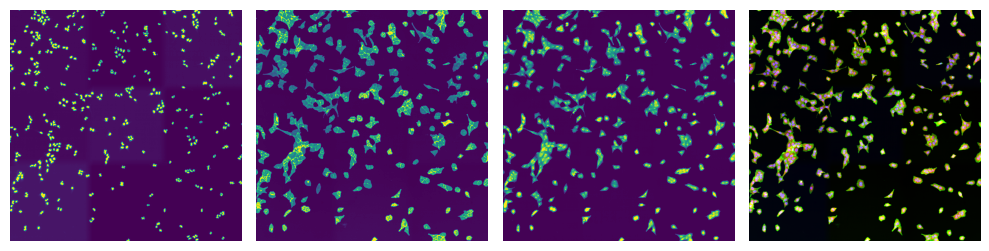

In [4]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

def colorize(im, color, clip_percentile=0.0):
    """
    Helper function to create an RGB image from a single-channel image using a
    specific color.
    """
    # Check that we do just have a 2D image
    if im.ndim > 2 and im.shape[2] != 1:
        raise ValueError("This function expects a single-channel image!")

    # Rescale the image according to how we want to display it
    im_scaled = im.astype(np.float32) - np.percentile(im, clip_percentile)
    im_scaled = im_scaled / np.percentile(im_scaled, 100 - clip_percentile)
    im_scaled = np.clip(im_scaled, 0, 1)

    # Need to make sure we have a channels dimension for the multiplication to work
    im_scaled = np.atleast_3d(im_scaled)

    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return im_scaled * color


def generate_composite(images, colors=None, plot=False):
    if colors is None:
        colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0), (1, 0, 1)]
    colorized = []
    for image, color in zip(images, colors, strict=False):
        image = colorize(image, color, 0.0)
        colorized.append(image)

    if plot:
        for i in colorized:
            plt.figure()
            plt.imshow(i)

    image = colorized[0]
    for i in range(len(colorized) - 1):
        image += colorized[i + 1]

    return np.clip(image, 0, 1)


fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].imshow(project.input_image[0])
axs[0].axis("off")

axs[1].imshow(project.input_image[1])
axs[1].axis("off")

axs[2].imshow(project.input_image[2])
axs[2].axis("off")

img = generate_composite(project.input_image)

axs[3].imshow(img)
axs[3].axis("off")

fig.tight_layout()

In [5]:
project.segment()

[27/01/2025 17:26:35] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./CytosolOnlySegmentationCellpose_435qed9x for CytosolOnlySegmentationCellpose
[27/01/2025 17:26:35] GPU Status for segmentation is True and will segment using the following device mps.
[27/01/2025 17:26:35] Segmentation will be performed wtih all 1 found GPUs.
[27/01/2025 17:26:35] GPU Status for segmentation is True with 1 GPUs found. Segmentation will be performed on the device mps with 1 processes per device in parallel.
[27/01/2025 17:26:35] Segmenting cytosol using the following model: cyto2


/Users/sophia/mambaforge/envs/scportrait_new/lib/python3.10/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)


[27/01/2025 17:26:48] Segmentation seg_all_cytosol written to sdata object.
[27/01/2025 17:26:48] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./CytosolOnlySegmentationCellpose_435qed9x'>


(-0.5, 3036.5, 3038.5, -0.5)

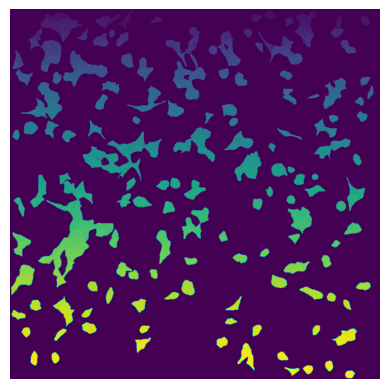

In [6]:
plt.figure()
plt.imshow(project.sdata["seg_all_cytosol"])
plt.axis("off")

[27/01/2025 17:26:48] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_bf4y5d7n for HDF5CellExtraction
[27/01/2025 17:26:48] Created new directory for extraction results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/extraction/data
[27/01/2025 17:26:48] Setup output folder at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/extraction/data
[27/01/2025 17:26:48] Found 1 segmentation masks for the given key in the sdata object. Will be extracting single-cell images based on these masks: ['seg_all_cytosol']
[27/01/2025 17:26:48] Using seg_all_cytosol as the main segmentation mask to determine cell centers.
[27/01/2025 17:26:50] Points centers_cells written to sdata object.
[27/01/2025 17:26:50] Extraction Details:
[27/01/2025 17:26:50] --------------------------------
[27/01/2025 17:26:50] Number of input image channels: 3
[27/01/2025 17

Processing cell batches: 100%|██████████| 5/5 [00:00<00:00, 16.13it/s]

[27/01/2025 17:26:51] Finished extraction in 0.42 seconds (1069.86 cells / second)
[27/01/2025 17:26:51] Transferring results to final HDF5 data container.
[27/01/2025 17:26:51] number of cells too close to image edges to extract: 9
[27/01/2025 17:26:51] A total of 9 cells were too close to the image border to be extracted. Their cell_ids were saved to file /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/extraction/removed_classes.csv.


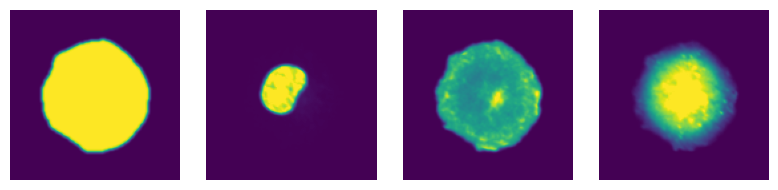

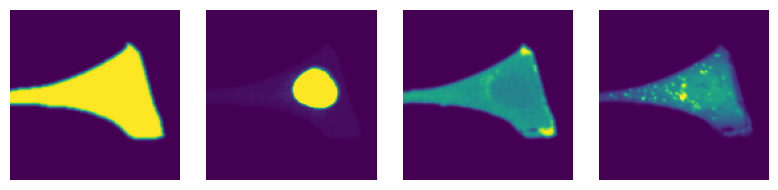

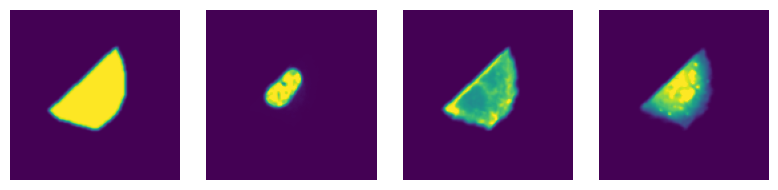

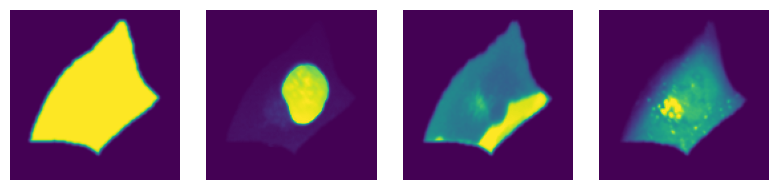

[27/01/2025 17:26:51] Transferring extracted single cells to .hdf5
[27/01/2025 17:26:51] single-cell index created.
[27/01/2025 17:26:51] single-cell data created
[27/01/2025 17:26:51] single-cell index labelled created.
[27/01/2025 17:26:51] channel information created.
[27/01/2025 17:26:52] Benchmarking times saved to file.
[27/01/2025 17:26:52] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_bf4y5d7n'>


In [7]:
project.extract()

(444, 4, 128, 128)


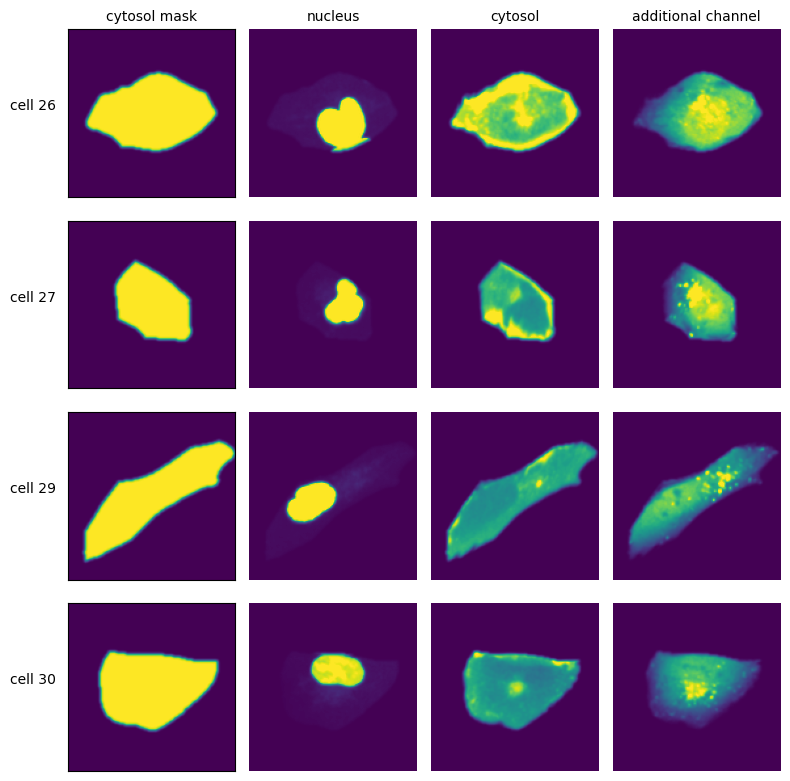

In [8]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print(images.shape)

    n_cells = [2, 3, 4, 5]
    fig, axs = plt.subplots(len(n_cells), 4, figsize=(4 * 2, len(n_cells) * 2))
    labels = ["cytosol mask", "nucleus", "cytosol", "additional channel"]

    for i, id in enumerate(n_cells):
        cell_id = index[id][1]
        image = images[id]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)
    fig.tight_layout()

In [9]:
project.featurize()

Using extraction directory: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/extraction/data/single_cells.h5
[27/01/2025 17:26:52] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/CellFeaturizer_lhpl75sp for CellFeaturizer
[27/01/2025 17:26:52] Started CellFeaturization of all available channels.
[27/01/2025 17:26:52] Overwrite flag is set, deleting existing directory for featurization results.
[27/01/2025 17:26:52] Created new directory for featurization results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/featurization/complete_CellFeaturizer
[27/01/2025 17:26:52] CPU specified in config file but MPS available on system. Consider changing the device for the next run.
[27/01/2025 17:26:52] Reading data from path: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/extract

In [3]:
# load classification results
results = pd.read_csv(f"{project_location}/featurization/complete_CellFeaturizer/calculated_image_features.csv")
results

,cytosol_area,1_mean_cytosol,1_median_cytosol,1_quant75_cytosol,1_quant25_cytosol,1_summed_intensity_cytosol,1_summed_intensity_area_normalized_cytosol,2_mean_cytosol,2_median_cytosol,2_quant75_cytosol,...,2_summed_intensity_cytosol,2_summed_intensity_area_normalized_cytosol,3_mean_cytosol,3_median_cytosol,3_quant75_cytosol,3_quant25_cytosol,3_summed_intensity_cytosol,3_summed_intensity_area_normalized_cytosol,label,cell_id
0,6927.0,0.074052,0.0,0.026459,0.0,1213.26010,0.175149,0.218768,0.0,6.166992e-01,...,3584.2990,0.517439,0.110609,0.0,1.227570e-01,0.0,1812.2202,0.261617,0,22
1,3981.0,0.055688,0.0,0.000000,0.0,912.39030,0.229186,0.109109,0.0,0.000000e+00,...,1787.6366,0.449042,0.096703,0.0,0.000000e+00,0.0,1584.3877,0.397987,0,25
2,5229.0,0.076646,0.0,0.019680,0.0,1255.77280,0.240155,0.204406,0.0,1.302185e-01,...,3348.9834,0.640463,0.153195,0.0,3.272247e-02,0.0,2509.9450,0.480005,0,26
3,3442.0,0.046033,0.0,0.000000,0.0,754.20953,0.219120,0.104464,0.0,0.000000e+00,...,1711.5461,0.497253,0.091717,0.0,0.000000e+00,0.0,1502.6848,0.436573,0,27
4,5463.0,0.057873,0.0,0.008547,0.0,948.19820,0.173567,0.135609,0.0,7.273865e-02,...,2221.8250,0.406704,0.108411,0.0,1.079178e-02,0.0,1776.2028,0.325133,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,4209.0,0.034677,0.0,0.000000,0.0,568.15045,0.134985,0.142048,0.0,2.533197e-07,...,2327.3137,0.552937,0.090516,0.0,5.960465e-08,0.0,1483.0109,0.352343,0,496
440,3285.0,0.059075,0.0,0.000000,0.0,967.88180,0.294637,0.102966,0.0,0.000000e+00,...,1686.9893,0.513543,0.082061,0.0,0.000000e+00,0.0,1344.4891,0.409281,0,497
441,5578.0,0.037257,0.0,0.001707,0.0,610.42194,0.109434,0.203797,0.0,2.258301e-01,...,3339.0146,0.598604,0.124447,0.0,1.148605e-02,0.0,2038.9375,0.365532,0,498
442,5595.0,0.052219,0.0,0.002640,0.0,855.55720,0.152915,0.178292,0.0,3.445435e-01,...,2921.1380,0.522098,0.131465,0.0,4.846191e-02,0.0,2153.9185,0.384972,0,499


In [13]:
#test selection workflow
selected_cells_large = results[results.cytosol_area > 4500]["cell_id"].tolist()
selected_cells_small = results[results.cytosol_area < 3000]["cell_id"].tolist()

cells_to_select = [
    {"name": "large_cells", "classes": selected_cells_large, "well": "A1"},
    {"name": "small_cells", "classes": selected_cells_small, "well": "B1"},
]

marker_0 = (0, 0)
marker_1 = (2000, 0)
marker_2 = (0, 2000)

calibration_marker = np.array([marker_0, marker_1, marker_2])

[27/01/2025 18:09:21] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./LMDSelection_re2__zdr for LMDSelection
[27/01/2025 18:09:21] Selection process started.


Processing cell batches: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


[27/01/2025 18:09:27] Temporary directory not found, skipping cleanup
[27/01/2025 18:09:27] Temporary directory not found, skipping cleanup
[27/01/2025 18:09:27] Temporary directory not found, skipping cleanup
[27/01/2025 18:09:28] Coordinate lookup index calculation took 6.79692495893687 seconds.
No configuration for shape_erosion found, parameter will be set to 0
No configuration for binary_smoothing found, parameter will be set to 3
No configuration for convolution_smoothing found, parameter will be set to 15
No configuration for rdp_epsilon found, parameter will be set to 0.1
No configuration for xml_decimal_transform found, parameter will be set to 100
No configuration for distance_heuristic found, parameter will be set to 300
No configuration for join_intersecting found, parameter will be set to True
Path optimizer used for XML generation: hilbert
cell set 0 passed sanity check
cell set 1 passed sanity check
Loading coordinates from external source
Processing cell sets in paralle

dilating shapes: 100%|██████████| 208/208 [00:04<00:00, 48.58it/s]


0 shapes that were intersecting were found and merged.


calculating polygons:   0%|          | 0/34 [00:00<?, ?it/s]

0 shapes that were intersecting were found and merged.


calculating polygons: 100%|██████████| 34/34 [00:03<00:00, 10.34it/s]


Current path length: 34,667.38 units


creating shapes: 100%|██████████| 81/81 [00:02<00:00, 34.48it/s]


Optimized path length: 15,473.04 units
Optimization factor: 2.2x


calculating polygons:   0%|          | 0/81 [00:00<?, ?it/s]

Plotting shapes in debug mode is not supported in multi-threading mode.
Saving plots to disk instead.
collecting cell sets:  50%|█████     | 1/2 [00:12<00:12, 12.14s/it]

calculating polygons: 100%|██████████| 81/81 [00:08<00:00,  9.56it/s]


Current path length: 82,683.68 units
Optimized path length: 27,214.13 units
Optimization factor: 3.0x
Plotting shapes in debug mode is not supported in multi-threading mode.
Saving plots to disk instead.
collecting cell sets: 100%|██████████| 2/2 [00:21<00:00, 10.56s/it]


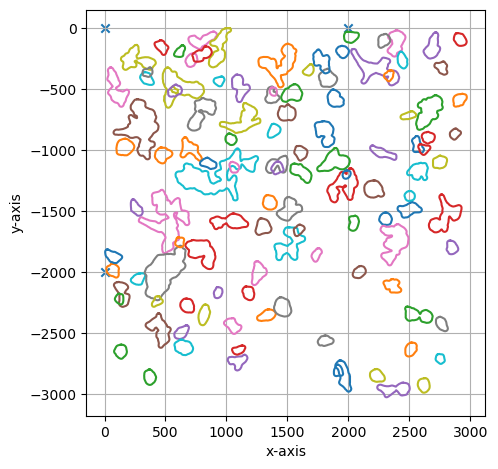

===== Collection Stats =====
Number of shapes: 115
Number of vertices: 16,789
Mean vertices: 146
Min vertices: 60
5% percentile vertices: 71
Median vertices: 103
95% percentile vertices: 332
Max vertices: 700
[0 0]
[      0 -200000]
[200000      0]
[27/01/2025 18:09:49] Saved output at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/selection/large_cells_small_cells.xml
[27/01/2025 18:09:50] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./LMDSelection_re2__zdr'>


In [14]:

project.selection_f.segmentation_channel_to_select = "seg_all_cytosol" #update to the correct channel for this notebook with out loading a different config
project.select(cells_to_select, calibration_marker)